# [EX1] Data collection

## 1.1 Get the list of animes


### Libraries

In [2]:
# core libraries
import requests
from bs4 import BeautifulSoup

# for better time view 
from tqdm import tqdm

### Creating the anime_url.txt file

We are creating a file called "anime.txt" conteining the url of each anime in the 400 pages (actually 383) of the top anime rank list of the MyAnimeList site. 

* We initialize a filename and then we are doing a for loop over the 400 pages. If the url "exist" so the response == 200 and we can collect the 50 url in that page, otherwise if the response == 400, the page doesn't exist and we exit from the loop, no more interest in continue to loop (no anime url to collect).

* The url scrabbing consist on using BeautifulSoup to inspect the whole html page to find where the url of the anime are. In particolar under the < tr>..< /tr> and < a>..< /a> we can view all the link in the pages. Moreover the anime url are associated with an "id=#areaXXX" class. We get there and gather the right link.
```
<a href="https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood" id="#area5114" rel="#info5114">Fullmetal Alchemist: Brotherhood</a>
```


In [3]:
filename = r"./anime_url.txt"
with open(filename,'w', encoding='utf-8') as f:
    for page in tqdm(range(0, 400)):
        url = "https://myanimelist.net/topanime.php?limit="+str(page*50)
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            for tag in soup.find_all("tr"):
                links = tag.find_all("a")
                for link in links:
                    if type(link.get("id")) == str and len(link.contents[0]) > 1:
                        f.write(link.get("href"))
                        f.write("\n")
        else:
            print("End with page count: ", page)
            break

 96%|████████████████████████████████████████████████████████████████████████████▌   | 383/400 [05:02<00:13,  1.27it/s]

End with page count:  383


## 1.2 Crawl animes

We now need to collect for each anime the html and store it in a .html file. The anime needs to follow the ranking page of the MyAnimeList, i.e 50 anime for page.

For this we begin to create a list called "lines" that store all the link of the anime. We use this method instead of open directly the .txt file in for loop to split the crawl part among the group.

In [330]:
filename = r"./anime_url.txt"

lines = []
with open(filename, "r", encoding='utf-8') as f:
        lines = f.readlines()

In [331]:
# view the first 5 and last 5 anime url collected
lines[:5], lines[-5:]

(['https://myanimelist.net/anime/5114/Fullmetal_Alchemist__Brotherhood\n',
  'https://myanimelist.net/anime/28977/Gintama°\n',
  'https://myanimelist.net/anime/38524/Shingeki_no_Kyojin_Season_3_Part_2\n',
  'https://myanimelist.net/anime/9253/Steins_Gate\n',
  'https://myanimelist.net/anime/42938/Fruits_Basket__The_Final\n'],
 ['https://myanimelist.net/anime/42383/Konbini_Shoujo_Z\n',
  'https://myanimelist.net/anime/10564/Korogashi_Ryouta\n',
  'https://myanimelist.net/anime/50237/Kyonyuu_Elf_Oyako_Saimin\n',
  'https://myanimelist.net/anime/49876/Mahou_Shoujo_Elena_DVD-BOX_Special\n',
  'https://myanimelist.net/anime/49762/Mama_x_Holic__Miwaku_no_Mama_to_Amaama_Kankei_-_The_Animation'])

### Libraries

In [332]:
# core libraries
import requests
from bs4 import BeautifulSoup
from time import sleep
# for time view
from tqdm import tqdm

### The Crawl

We begin creating the pages needed to store the anime. 

The pages from 1 to 383 are stored in the Anime_pages folder.

In [333]:
import os

for page in tqdm(range(1, 384)):
    folder = "page"+str(page)
    path = "./Anime_pages/"+folder
    os.mkdir(path)

100%|██████████████████████████████████████████████████████████████████████████████| 383/383 [00:00<00:00, 3978.07it/s]


Now we create a double loop, over the pages and over the 50 anime, to collect the whole html and save it in the correct pages.

For group division, here the loop goes from page 1 to 130. For have the complete loop we can iter over 0 to 383.
We also use a "SLEEP" to avoid the robot cheack while scrabbing the html of the page.

Because we cant have time to re-run the cell of the crawl of the 384 anime, we run for only the first page and will load the screenshot of the all work done on the total of pages after.

In [334]:
for page in tqdm(range(0, 1)):  
    # positioning in the right folder page
    folder = "/page"+str(page+1)
    for i in range(0,50):   
        page_now = 50*page
        # gather the url
        url = lines[page_now+i]
        response = requests.get(url)
        # name of the file   
        filename = r"./Anime_pages"+folder+"/anime_"+str(page_now+i+1)+".html"
        with open(filename,'w', encoding='utf-8') as f:
            f.write(response.text)
        # add a sleep to avoid the "robot cheack" in fast scrabbing the html
        sleep(5)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:54<00:00, 354.32s/it]


In [324]:
# Verify check

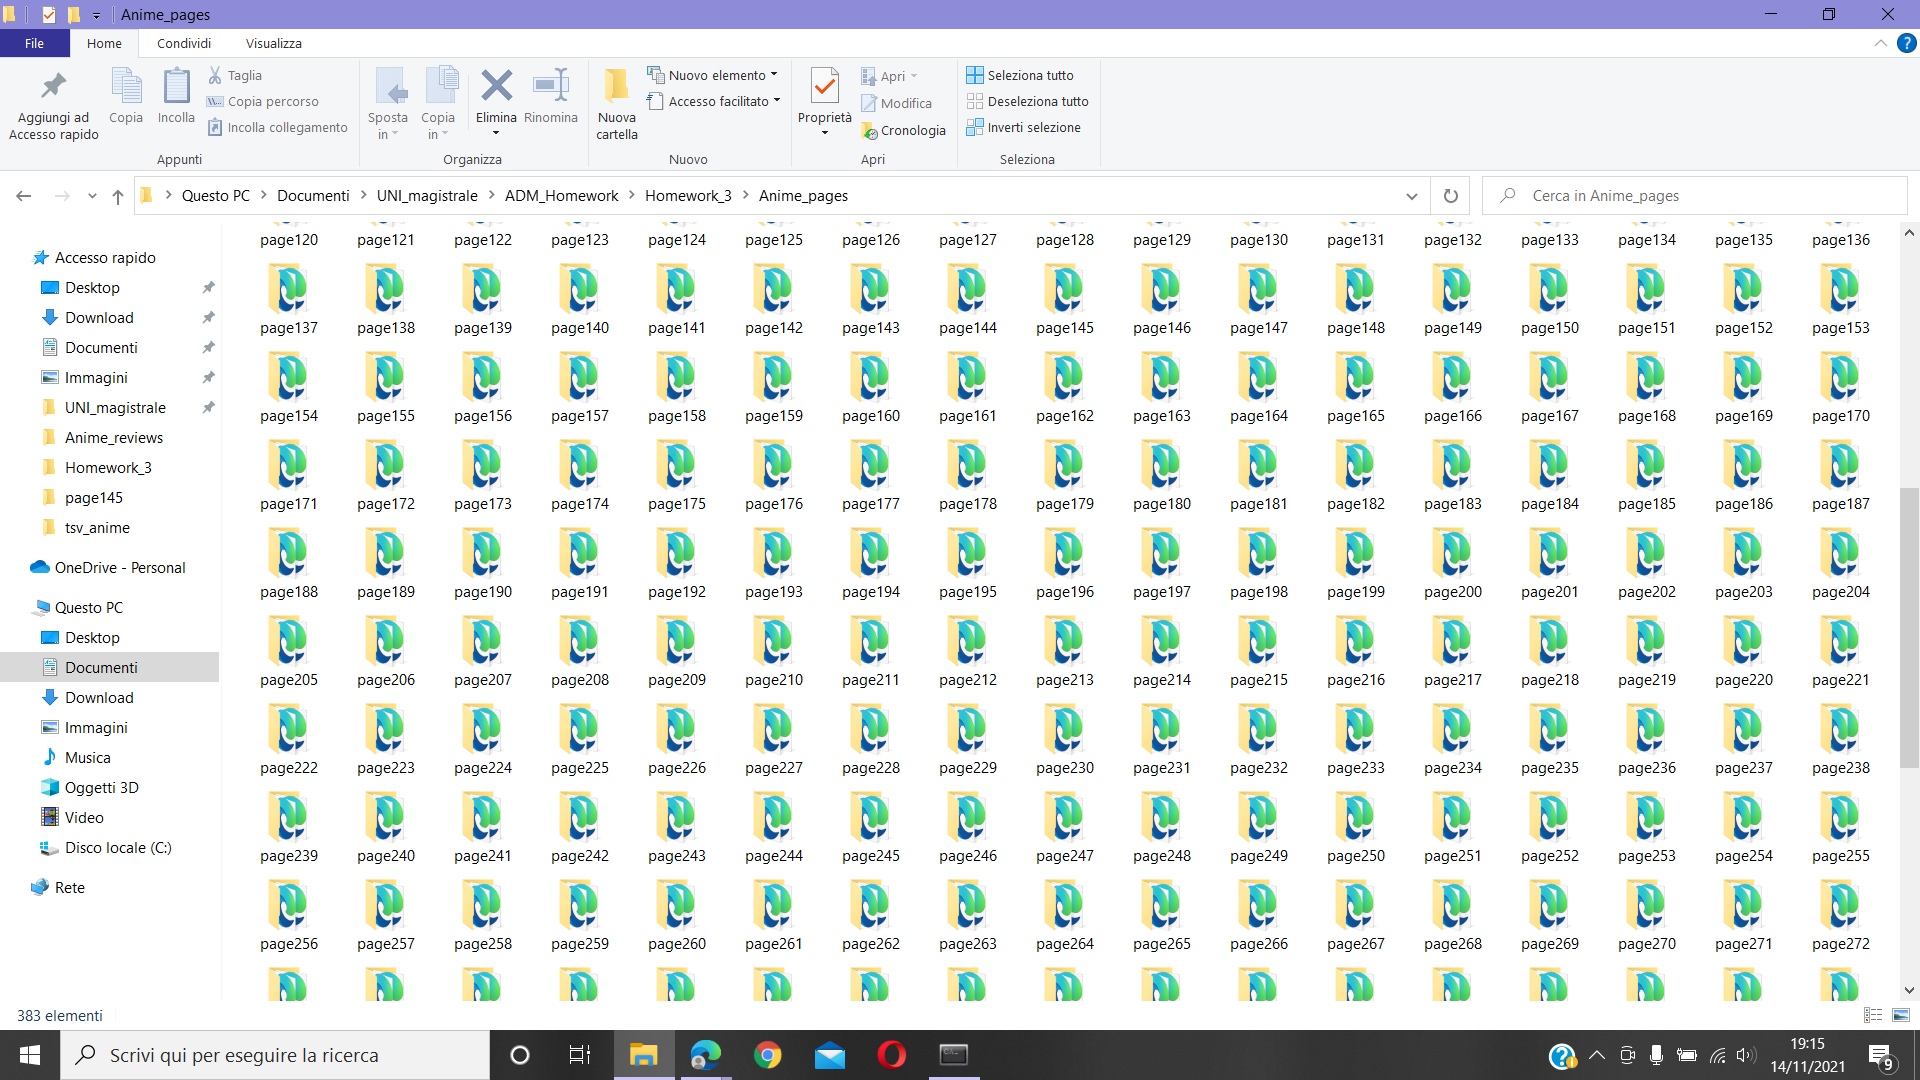

In [327]:
from PIL import Image
myImage = Image.open("Screenshot2.png");
myImage

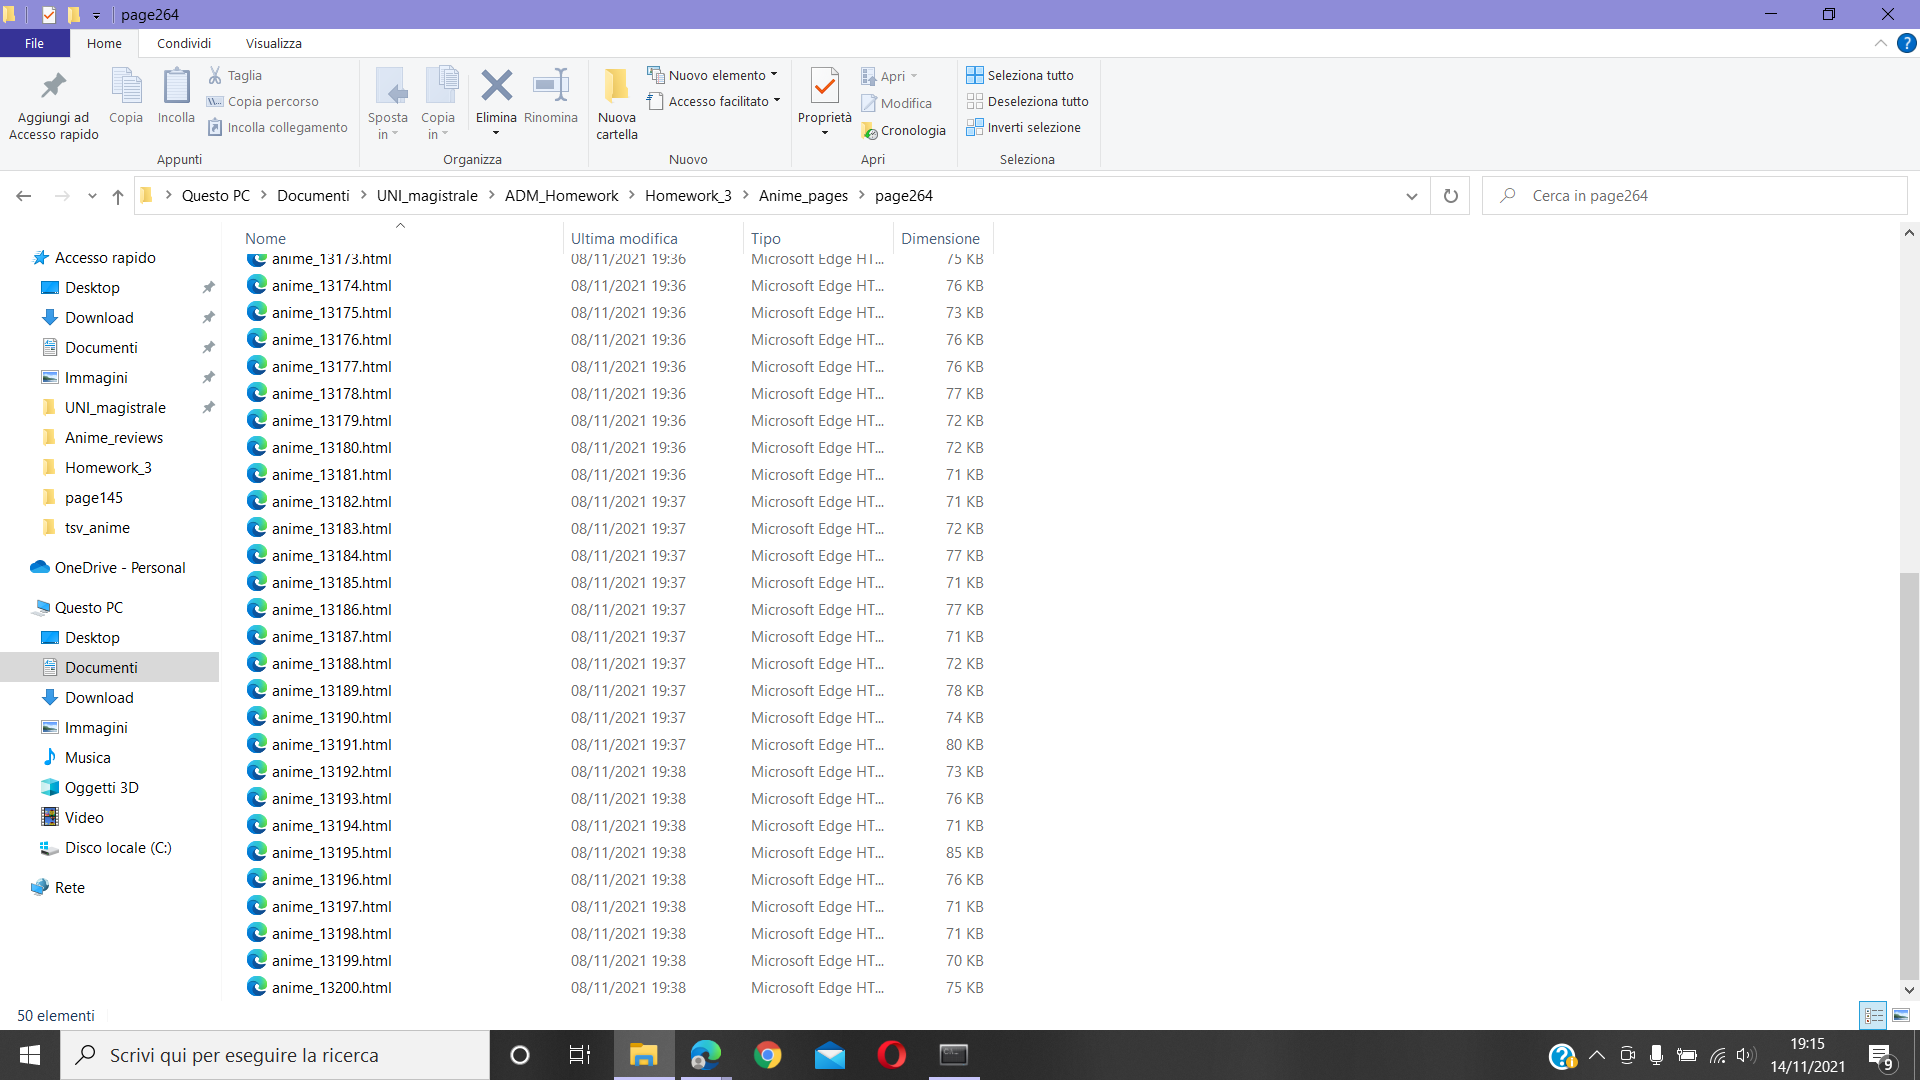

In [328]:
myImage = Image.open("Screenshot1.png");
myImage

## 1.3 Parse downloaded pages


### Importing libraries

In [5]:
# core libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import re
# usefull libraries to manage file in folder 
import os
from natsort import natsorted
# for time view
from tqdm import tqdm

Because there are vary information to collect about an anime, to have a clear notebook we split in functions our parsing in the "functions.py" file.

We divide the crawl in three function (or three part):
* scrabbing_anime1:  Title, Type, number of Episode, Realease / End date
* scrabbing_anime2:  number of Members, Score, Users, Rank, Popularity
* scrabbing_anime3:  Synopsis, anime Related, anime Characters and Voices, anime Staff

Also we have a function called: 
* parse_time:  a function that parse the date collected from the html in a datetime object

The parsing process is this: we create a list called "anime_info" in which we collect all the info about an anime. Than using this list we create a dataframe which columns are coming from the "attrs" list (a list containing the title of each attributes) and save it as a .tsv file.

In [6]:
# importing the functions on functions.py file
import functions

Let's view the process with one anime

In [234]:
# name of the columns 
attrs = ["animeTitle", "animeType", "animeNumEpisode","releaseDate","endDate","animeNumMembers","animeScore","animeUsers","animeRank",
         "animePopularity","animeDescription","animeRelated","animeCharacters","animeVoices","animeStaff"]

# positioning 
folder = r"./Anime_pages/page1/"
anime = "anime_1.html"

# take the html of the file 
with open(folder+anime, "r",  encoding='utf-8') as fp:
    soup = BeautifulSoup(fp, "html.parser")

# collecting the information
anime_info = []
anime_info + functions.scrabbing_anime1(soup, anime_info)
anime_info + functions.scrabbing_anime2(soup, anime_info)
anime_info + functions.scrabbing_anime3(soup, anime_info)


# Creating the DataFrame
df = pd.DataFrame([anime_info], columns = attrs)
# change attributes to str
str_cols = ["animeTitle", "animeType", "animeDescription"]
df[str_cols] = df[str_cols].astype("string")
# Creating the tsv file, take the anime number (the id)
name = re.sub(".html","",anime)
df.to_csv("./tsv_anime/"+name+".tsv", index = False, sep = "\t")

In [235]:
# type cheaking 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animeTitle        1 non-null      string        
 1   animeType         1 non-null      string        
 2   animeNumEpisode   1 non-null      int64         
 3   releaseDate       1 non-null      datetime64[ns]
 4   endDate           1 non-null      datetime64[ns]
 5   animeNumMembers   1 non-null      int64         
 6   animeScore        1 non-null      float64       
 7   animeUsers        1 non-null      int64         
 8   animeRank         1 non-null      int64         
 9   animePopularity   1 non-null      int64         
 10  animeDescription  1 non-null      string        
 11  animeRelated      1 non-null      object        
 12  animeCharacters   1 non-null      object        
 13  animeVoices       1 non-null      object        
 14  animeStaff        1 non-null  

For all the anime we proceed in this way:

In [62]:
attrs = ["animeTitle", "animeType", "animeNumEpisode","releaseDate","endDate","animeNumMembers","animeScore","animeUsers","animeRank",
         "animePopularity","animeDescription","animeRelated","animeCharacters","animeVoices","animeStaff"]


# iterate from page 1 to 384 
# ( remember the page are from 1 to 383 and range goes from 1 to 384 )
for page in tqdm(range(1,384)):
    # positioning
    folder = "./Anime_pages/page"+str(page)
    # iterate over the "ordered" list of anime
    for anime in natsorted(os.listdir(folder)):
            # open the anime
            with open(folder + "/" + anime, "r",  encoding='utf-8') as fp:
                soup = BeautifulSoup(fp, "html.parser")
            anime_info = []
            anime_info + functions.scrabbing_anime1(soup, anime_info)
            anime_info + functions.scrabbing_anime2(soup, anime_info)
            anime_info + functions.scrabbing_anime3(soup, anime_info)
        
            # Creating the DataFrame
            df = pd.DataFrame([anime_info], columns = attrs)
            # change attributes to str
            str_cols = ["animeTitle", "animeType", "animeDescription"]
            df[str_cols] = df[str_cols].astype("string")
            # Creating the tsv file, take the anime number to match the txt url row and the tsv
            name = re.sub(".html","",anime)
            df.to_csv("./tsv_anime/"+name+".tsv", index = False, sep = "\t")

100%|████████████████████████████████████████████████████████████████████████████████| 383/383 [53:29<00:00,  8.38s/it]


# [EX2] Search Engine


## 2.0 Preprocessing the documents

### Let's collect our corpus of documents

First of all lets gather all the documents in one list.
* documents: lists of document. Each document correspond to an anime description.

In [66]:
from tqdm import tqdm
from natsort import natsorted
import os
import pandas as pd

In [67]:
documents = []

# positioning
folder = r"./tsv_anime/"
# iter over the file
for anime in tqdm(natsorted(os.listdir(folder))):
    df = pd.read_csv(folder+anime, sep = "\t")
    # take only the description
    documents.append(df["animeDescription"][0])

100%|███████████████████████████████████████████████████████████████████████████| 19116/19116 [02:16<00:00, 139.74it/s]


In [153]:
# view a document 
documents[0]

'After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse\'s body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse\'s soul in the physical realm by binding it to a hulking suit of armor.\n\n\nThe brothers are rescued by their neighbor Pinako Rockbell and her granddaughter Winry. Known as a bio-mechanical engineering prodigy, Winry creates prosthetic limbs for Edward by utilizing "automail," a tough, versatile metal used in robots and combat armor. After years of training, the Elric brothers set off on a quest to restore their bodies by locating the Philosopher\'s Stone—a powerful gem that allows an alchemist to defy the traditional laws of Equivalent Exchange.\n\n\nAs Edward becomes an

### Clean the documents

Now let's cleaning all the documents. This step is colled preprocessing. We follow this order:
- 1) expand contraction type 1 + Normalization (capital lower words)
- 2) splitting number from text (ex 25min) and removing contraction type 2 
- 3) removing punctuation
- 4) Tokanize. We divide the string in words.
- 5) removing stopwords
- 6) removing some other words or non-text string like […•♥→☆‘★] or japanese glyphe
- 7) lemmatizing and stemming 

For contraction type 1 and 2 see below

Let's inspect the document to see what we can delete and what no:
- for example: "Philosopher's Stone—a powerful" << This is dash
- but "bio-mechanical engineering" << This is hyphen
- but we also have "15-year" << hyphen <br>

We decide to remove the hypen and the dash

We encounter also some special characters like: … • ♥ →☆‘ . We remove them.

At the end of a lot of anime description there is a "Written MAL Rewrite". We remove that.

When tokanizing there is also the saxon genitive " 's ": we remove that.

Also we encounter a lot of contraction form: using wikipedia https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
we store them in a dictionary and restore the long form.
Using the same idea we have term like: min or sec, so we use a second dictionary to restore the original form.

In [287]:
# core libraries 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re

# functions.py
import functions

In [243]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he shall",
"he'll've": "he shall have",
"he's": "he has",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has",
"i'd": "I had",
"i'd've": "I would have",
"i'll": "I shall",
"i'll've": "I shall have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it shall",
"it'll've": "it shall have",
"it's": "it has",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she shall",
"she'll've": "she shall have",
"she's": "she has",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that has",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there has",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they shall",
"they'll've": "they shall have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall",
"what'll've": "what shall have",
"what're": "what are",
"what's": "what has",
"what've": "what have",
"when's": "when has",
"when've": "when have",
"where'd": "where did",
"where's": "where has",
"where've": "where have",
"who'll": "who shall",
"who'll've": "who shall have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you shall",
"you'll've": "you shall have",
"you're": "you are",
"you've": "you have"
}

In [244]:
contractions2 = {
"min": "minute",
"sec": "second"
}

In [288]:
def pre_processing(documents):
    stop = stopwords.words("english")
    lmtzr = WordNetLemmatizer()
    remove = ["Written", "MAL", "Rewrite"]+["'s"]+[""]
    ps = PorterStemmer()
    
    # removing contraction + Normalization
    document_tmp = functions.replace_words(documents.lower(), contractions)
    # splitting number and text 
    document_tmp = " ".join(re.split(r"([0-9]+)([a-z]+)",document_tmp))
    document_tmp = functions.replace_words(document_tmp, contractions2)
    # removing punctuation
    document_tmp = re.sub(r"[{}\—ー``\"'“''――]".format(string.punctuation)," ",document_tmp)
    # Tokenizing 
    document_tmp = word_tokenize(document_tmp) 
    # removing stopwords
    document_tmp = [ word for word in document_tmp if word not in stop]
    # removing "Written MAL Rewrite" and we want only the alphanumeric text NO […•♥→☆‘★]
    document_tmp = [ re.sub(r"[^a-zA-Z0-9]", "", word).strip() for word in document_tmp]
    document_tmp = [ word for word in document_tmp if word not in remove]
    # lemmatize
    document_tmp = [ lmtzr.lemmatize(word) for word in document_tmp]
    # stemming 
    document_tmp = [ ps.stem(word) for word in document_tmp]

    return document_tmp

- documents_clean: is a list of list of the documents cleaned. Each list contain the tokenize cleaning document text.

In [248]:
# cleaning the documents
documents_clean = []
for d in documents:
    documents_clean.append(pre_processing(d))

Let's view how a document is processed:

In [249]:
documents_clean[0][:10]

['horrif',
 'alchemi',
 'experi',
 'go',
 'wrong',
 'elric',
 'household',
 'brother',
 'edward',
 'alphons']

### Creating vocabulary

In [250]:
# core libraries
import itertools
import numpy as np

I will create a list of each unique word among the all documents

In [251]:
# the list of all unique words
word_list = list(set(list(itertools.chain.from_iterable(documents_clean))))

Creating a dictionary that maps each word to an integer: we use the function zip to assign to each word an order integer.

In [252]:
vocabolary = dict(zip(word_list, range(len(word_list))))

In [253]:
len(vocabolary)

36063

In [254]:
# view the vocabolary
count = 0
for key, mapped_int in vocabolary.items():
    count +=1
    print(key,"-->",mapped_int)
    if count == 10: break

maetel --> 0
giraff --> 1
mikumo --> 2
softwar --> 3
aguri --> 4
beg --> 5
marriag --> 6
ingeni --> 7
senou --> 8
flaminuteg --> 9


Saving the dictionary in a .json file

In [255]:
import json

file = open("vocabolary.json", "w", encoding = "utf-8")
json.dump(vocabolary, file)
file.close()

Import the saved vocabolary.

In [256]:
with open( "vocabolary.json" ) as f:
    vocabolary = json.load( f )

## 2.1. Conjunctive query

For this type of search engine we need only to have a search engine based on the query appear or not in each documents. 


* ### Prepare the mapped document

To do this we will create an array of documents of each len(document_j) in which thare are converted the word into integer based on the vocabolary

We will use numpy array for time optimitation.

In [257]:
def word_to_int(document, vocabolary):
    int_doc = np.zeros(len(document), dtype = np.int64)
    # iterating over the document that has len(d)<<len(vocabolary)
    # change the value of the document, otherwise remain zero
    for i, word in enumerate(document):
        # vocabolary[word] is the mapping function that return an integer i.e the index
        int_doc[i] = vocabolary[word]
        
    return np.sort(int_doc)

* documents_mapped: is a list of list that have the words mapped

In [258]:
documents_mapped = []
for d in documents_clean:
    documents_mapped.append(word_to_int(d,vocabolary))

In [259]:
# view a docoument mapped 
documents_mapped[0]

array([  529,   981,  1111,  1204,  1409,  1700,  1703,  1757,  2535,
        2535,  3048,  3414,  3615,  4186,  4235,  4585,  4689,  5040,
        5083,  5083,  5083,  5358,  5358,  5753,  5928,  5928,  6569,
        6760,  7056,  7528,  7866,  7962,  7963,  8939,  9251,  9347,
        9835, 10487, 10685, 10762, 10762, 10762, 10811, 10850, 10983,
       11828, 12320, 12763, 12843, 13126, 13175, 13380, 13576, 14657,
       14750, 14750, 14856, 15481, 15654, 15663, 15931, 15975, 16087,
       16767, 17220, 17240, 17326, 17327, 17376, 17384, 17657, 19652,
       19882, 19907, 20633, 20755, 20820, 20974, 20974, 21010, 21335,
       21400, 21696, 21951, 22151, 23298, 23298, 23298, 23298, 23332,
       23332, 23735, 24082, 24676, 24927, 25703, 26188, 26387, 26644,
       27423, 27453, 27897, 29151, 29796, 31013, 31140, 31166, 31351,
       31673, 32223, 33600, 33736, 35454, 35989], dtype=int64)

* ### Inverted Index v1

In [260]:
from collections import defaultdict  

In [261]:
# initialize the Inverted_index
Inverted_index = defaultdict(list)

To compute the Inverted Index we iterating over each document. Every time we encounter a word (that is now a integer) we insert in the dictionary the id of the documents, which is the row index in documents_mapped or in our dataset of tsv / url.txt.

In [262]:
for i,d in enumerate(documents_mapped):
    for word in set(d):
        Inverted_index[str(word)].append(i)

In [263]:
# let's view the Inverted_index
count = 0
for key, lis in Inverted_index.items():
    count +=1
    print("word: ",key,"-->","documents: ", lis)
    if count == 1: break

word:  14856 --> documents:  [0, 126, 284, 293, 410, 458, 491, 579, 806, 857, 875, 1105, 1118, 1121, 1173, 1202, 1284, 1829, 1917, 2205, 2289, 2422, 2616, 2723, 2781, 2941, 2969, 3205, 3556, 3681, 4006, 4056, 4331, 4474, 4814, 5150, 5222, 5770, 5937, 6310, 6603, 6838, 7044, 7755, 8004, 8447, 8492, 8698, 8770, 8983, 9047, 10123, 10235, 10897, 11056, 12617, 14549, 15357, 15412, 15660, 16067, 16660, 17314, 17685, 17717, 17722, 17795, 17971, 17974, 18011, 18069, 18244, 18316, 18401, 18728, 18766]


Saving the Inverted Index in memory

In [264]:
import json

file = open("Inverted_index_v1.json", "w", encoding = "utf-8")
json.dump(Inverted_index, file)
file.close()

Import the saved inverted index

In [265]:
with open( "Inverted_index_v1.json" ) as f:
    Inverted_index = json.load( f )

* ### Searching

How it work:

* Given in input a query we first of all preprocessing like a document;
* then using the Inverted index we exctract the list corrisponding to each element (word) of the query, store them in a list of set (for intersection pourpose) called "index". 
* Than we intersect all the set for obtain the documents that match ALL the query elements.
* In the end we create the dataframe with the desire output.

In [266]:
def search_engine_v1(query_text):
    # pre-processing the query
    query_clean = pre_processing(query_text)
    query_int = word_to_int(query_clean, vocabolary)
    
    # for each element of the query we can obtain the list of doc 
    # in which the query element appears
    index = []
    
    for query in query_int:
        # creating a set of index (set is for intersection pourpose)
        index.append(set(Inverted_index[str(query)]))
    
    # intersect and obtain the documents that contain ALL the query
    index = list(index[0].intersection(*index))
    
    # taken the url of the anime list
    with open("./anime_url.txt", "r", encoding = "utf-8") as f:
        lines = f.readlines()
        
    # we are searching for the anime and the url corrisponding to the index
    # we found
    anime_path = []
    url = []

    for idx in index:
        # we need the +1 because we start indexing from 1
        name = "/anime_"+str(idx+1)+".tsv"
        anime_path.append(name)
        url.append(lines[idx])

    # creating the dataframe for view the result
    animes_df = []
    # folder of the anime_tsv
    folder = r"./tsv_anime/"
    # column I want
    cols = ["animeTitle","animeDescription"]
    for i,anime_tsv in enumerate(anime_path):
        df = pd.read_csv(folder+anime_tsv, sep = "\t", usecols = cols)
        # creating new column with the url
        df["animeURL"] = url[i]
        animes_df.append(df)
    
    frame = pd.concat(animes_df, ignore_index = True)
    display(frame)

#### Input and search

In [267]:
# input query 
query_text = input("Insert the query: ")

search_engine_v1(query_text)

Insert the query:  battle pirate


,animeTitle,animeDescription,animeURL
0,Beast Wars Second Chou Seimeitai Transformers:...,The movie begins with a space battle between t...,https://myanimelist.net/anime/5289/Beast_Wars_...
1,Last Exile: Ginyoku no Fam Movie - Over the Wi...,A recap film with some new scenes.\n\n\nThe Sk...,https://myanimelist.net/anime/31866/Last_Exile...
2,One Piece,"Gol D. Roger was known as the ""Pirate King,"" t...",https://myanimelist.net/anime/21/One_Piece\n
3,Battle Can²,Join this band of femme fatales as they sacrif...,https://myanimelist.net/anime/6025/Battle_Can²\n
4,Gintama.,After joining the resistance against the bakuf...,https://myanimelist.net/anime/34096/Gintama\n
5,One Piece Movie 2: Nejimaki-jima no Daibouken,Informed by the Thief Brothers his ship has be...,https://myanimelist.net/anime/460/One_Piece_Mo...
6,A-Ko The Versus,A-ko and B-ko are bounty hunters in an untamed...,https://myanimelist.net/anime/1295/A-Ko_The_Ve...
7,Slayers Revolution,Having lost the Sword of Light in the previous...,https://myanimelist.net/anime/4028/Slayers_Rev...
8,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,When Gintoki apprehends a movie pirate at a pr...,https://myanimelist.net/anime/15335/Gintama_Mo...
9,One Piece Movie 1,"Woonan is the legendary Great Gold Pirate, ear...",https://myanimelist.net/anime/459/One_Piece_Mo...


# 2.2 Conjunctive query & Ranking score

Now we want for our Inverted_index two element:

* $\text{tf}_{i,j}$: occurancy of term $j$ in document $i$
* $\text{idf}_{j}$: Inverse Document Frequency of term $j$

Define:

* n_words = total number of words in vocabolary
* n = number of documents

In [268]:
n = len(documents)
n_words = len(vocabolary)

Creating the $\text{tf}_{i,j}$ matrix:

* ### Prepare the mapped document

To do this we will create an array of documents of each len(document_j) in which thare are converted the word into integer based on the vocabolary

We will use numpy array for time optimitation.

In [269]:
# function that map document text to the relative tf

def word_to_int2(document, vocabolary):
    int_doc = np.zeros(len(vocabolary), dtype = np.int64)
    # iterating over the document that has len(d)<<len(vocabolary)
    # change the value of the document, otherwise remain zero
    for word in document:
        # vocabolary[word] is the mapping function that return an integer i.e the index
        int_doc[vocabolary[word]] += 1
        
    return int_doc

* $tf$: is a list of list that have the words mapped with is count

In [270]:
tf = []
for d in documents_clean:
    tf.append(word_to_int2(d,vocabolary))

In [271]:
# view a doc
tf[0][tf[0]>0]

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

Creating the $\text{idf}_{j}$ array:
* I need the $n_j$: number of documents containing term j

In [272]:
nj = np.zeros(n_words, dtype = np.float64)

# we create a numpy array of length n_words
# for each docoument we take the unique set of word
# and count
for d in documents_mapped:
    for word in set(d):
        nj[word] += 1

In [273]:
# view
nj

array([9., 9., 3., ..., 3., 1., 4.])

In [274]:
# creating idf_j

idf = np.zeros(n_words, dtype = np.float64)
idf = np.log(n/nj) / np.log(n)

$\text{tfIdf}_{ij} = \text{tf}_{ij} * \text{idf}_{j} $

In [275]:
tfIdf = np.multiply(tf,idf)

In [276]:
np.shape(tfIdf)

(19116, 36063)

* ### Inverted index v2

In [277]:
from collections import defaultdict  

In [278]:
Inverted_indexv2 = defaultdict(list)

To compute the Inverted Index we iterating over each document. Every time we encounter a word (that is now a integer) we insert in the dictionary the __tupla__ of _id_ of the documents and the _tfIdf_.

In [279]:
for i,d in enumerate(documents_mapped):
    for word in set(d):
        # append (idd_i, tfidf_ij)
        Inverted_indexv2[str(word)].append((i,tfIdf[i,int(word)]))

In [280]:
# view
count = 0
for key, lis in Inverted_indexv2.items():
    count +=1
    print(key,"-->",lis)
    if count == 1: break

14856 --> [(0, 0.5607009621666353), (126, 0.5607009621666353), (284, 0.5607009621666353), (293, 0.5607009621666353), (410, 0.5607009621666353), (458, 0.5607009621666353), (491, 1.1214019243332707), (579, 0.5607009621666353), (806, 0.5607009621666353), (857, 0.5607009621666353), (875, 0.5607009621666353), (1105, 0.5607009621666353), (1118, 0.5607009621666353), (1121, 0.5607009621666353), (1173, 0.5607009621666353), (1202, 0.5607009621666353), (1284, 0.5607009621666353), (1829, 0.5607009621666353), (1917, 0.5607009621666353), (2205, 0.5607009621666353), (2289, 0.5607009621666353), (2422, 0.5607009621666353), (2616, 0.5607009621666353), (2723, 0.5607009621666353), (2781, 0.5607009621666353), (2941, 0.5607009621666353), (2969, 0.5607009621666353), (3205, 0.5607009621666353), (3556, 0.5607009621666353), (3681, 0.5607009621666353), (4006, 0.5607009621666353), (4056, 0.5607009621666353), (4331, 0.5607009621666353), (4474, 0.5607009621666353), (4814, 1.1214019243332707), (5150, 0.5607009621666

Saving the Inverted Index in memory

In [281]:
import json

file = open("Inverted_index_v2.json", "w", encoding = "utf-8")
json.dump(Inverted_indexv2, file)
file.close()

Import the saved inverted index

In [282]:
with open( "Inverted_index_v2.json" ) as f:
    Inverted_indexv2 = json.load( f )

* ### Searching

To better have a use of the Inverted Index + Ranking we suppose that a __query is input as a text of unique word__.

We define than the cosine similarity as:
$$
\begin{equation}
\cos(q,d^i) =  \frac{\sum_{j: \hspace{0.1cm}  q_j=1} \text{tfIdf}_{ij}}{||d^i||*||q||}
\end{equation}
$$

Under this assumption we observe that: $||q|| = \sqrt(len(q)$

Recall: $d^i = [\text{tfIdf}_{i1}, \text{tfIdf}_{i2}, \ldots]$ 

In [283]:
# libraries to compute the manage the heap
import heapq

How is it work:

* we take a query text in input and preprocessing like a normal document. Than we obtain the "query_int" array of 0 and 1: q[j] = 1 if word_j in q, 0 otherwise;
* then using the Inverted index we exctract the list of tuple corrisponding to each element (word) of the query. We store also the len of each match list and the maximum list (we need it to manage the pointer of different length list);
* We now have a function "intersection_all" that return two things: a boolean variable, enough that is True if I have at least k document that match the all query and match list, that return the list of the index that match all the query if true or the original match list if False;
* Than the algorithm goes in two part:<br>
$\hspace{1cm}$  1. if True (I have at least k document) we compute the score of element in the list and return the top k<br>
$\hspace{1cm}$  2. if False, we compute the score af all the document and return the score ordered of the matches
* In the end: we create the dataframe of the documents ranked.

In [284]:
def search_engine2(query, k, tfIdf):
    # preprocessing the query
    query_clean = pre_processing(query)
    query_int = word_to_int2(query_clean, vocabolary)

    # initialize a match_list which store the list of match
    match_list = []
    # list of the length of the match 
    lenMatch = []
    # tupla = (#list, len(list))
    max_lenMatch = (0,-1)
    for i,query in enumerate(np.where(query_int>0)[0]):
        lis = Inverted_indexv2[str(query)]
        match_list.append(lis)
        tmplis, tmplen = i, len(lis)
        if tmplen>max_lenMatch[1]:
            max_lenMatch = (tmplis,tmplen)
        lenMatch.append(len(lis))
    
    enough, match_list = functions.intersection_all(k, match_list)
    m = len(query_clean)
    if enough:
        scores = functions.scoresK(match_list, tfIdf, m, query_int)
        topscore, topk = functions.find_topK(k, scores)
    else:
        scores = functions.scoresALL(match_list, tfIdf, m, lenMatch)
        # the top k documents are ALL the documents
        k = len(scores)
        topscore, topk = functions.find_topK(k, scores)
            
    # search the url
    with open("./anime_url.txt", "r", encoding = "utf-8") as f:
        lines = f.readlines()
        
    # we are searching for the anime and the url 
    anime_path = []
    url = []

    for idx in topk:
        # we need the +1 because we start indexing from 1
        name = "/anime_"+str(idx+1)+".tsv"
        anime_path.append(name)
        url.append(lines[idx])

    # creating the dataframe for view the result
    animes_df = []
    # folder of the anime_tsv
    folder = r"./tsv_anime/"
    # column I want
    cols = ["animeTitle","animeDescription"]
    for i,anime_tsv in enumerate(anime_path):
        df = pd.read_csv(folder+anime_tsv, sep = "\t", usecols = cols)
        # creating new column
        df["animeURL"] = url[i]
        df["animeScores"] = topscore[i]
        animes_df.append(df)
    
    frame = pd.concat(animes_df, ignore_index = True)
    display(frame)
    
    return

### Input and searching

In [285]:
query = input("Insert the query: ")
k = int(input("Insert k: "))

search_engine2(query, k, tfIdf)

Insert the query:  battle pirate
Insert k:  10


,animeTitle,animeDescription,animeURL,animeScores
0,One Piece,"Gol D. Roger was known as the ""Pirate King,"" t...",https://myanimelist.net/anime/21/One_Piece\n,0.366997
1,One Piece Movie 1,"Woonan is the legendary Great Gold Pirate, ear...",https://myanimelist.net/anime/459/One_Piece_Mo...,0.298815
2,Battle Can²,Join this band of femme fatales as they sacrif...,https://myanimelist.net/anime/6025/Battle_Can²\n,0.256860
3,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,When Gintoki apprehends a movie pirate at a pr...,https://myanimelist.net/anime/15335/Gintama_Mo...,0.236275
4,One Piece: Oounabara ni Hirake! Dekkai Dekkai ...,"The story opens on Pirate Zap's ship, where tw...",https://myanimelist.net/anime/1237/One_Piece__...,0.191371
5,One Piece Movie 2: Nejimaki-jima no Daibouken,Informed by the Thief Brothers his ship has be...,https://myanimelist.net/anime/460/One_Piece_Mo...,0.161223
6,A-Ko The Versus,A-ko and B-ko are bounty hunters in an untamed...,https://myanimelist.net/anime/1295/A-Ko_The_Ve...,0.156778
7,Last Exile: Ginyoku no Fam Movie - Over the Wi...,A recap film with some new scenes.\n\n\nThe Sk...,https://myanimelist.net/anime/31866/Last_Exile...,0.150042
8,Slayers Revolution,Having lost the Sword of Light in the previous...,https://myanimelist.net/anime/4028/Slayers_Rev...,0.145129
9,One Piece 3D2Y: Ace no shi wo Koete! Luffy Nak...,After suffering great personal loss during the...,https://myanimelist.net/anime/25161/One_Piece_...,0.133564


In [286]:
query = input("Insert the query: ")
k = int(input("Insert k: "))

search_engine2(query, k, tfIdf)

Insert the query:  sasuke naruto sakura
Insert k:  10


,animeTitle,animeDescription,animeURL,animeScores
0,"Naruto: Shippuuden - Shippuu! ""Konoha Gakuen"" Den",Naruto school special.\n\n\nNaruto is a new co...,https://myanimelist.net/anime/4134/Naruto__Shi...,0.664881
1,Naruto: The Cross Roads,The operation to find a missing person goes aw...,https://myanimelist.net/anime/7367/Naruto__The...,0.597544
2,Naruto: Shippuuden Movie 6 - Road to Ninja,"Returning home to Konohagakure, the young ninj...",https://myanimelist.net/anime/13667/Naruto__Sh...,0.465943
3,Naruto Soyokazeden Movie: Naruto to Mashin to ...,While enjoying a barbecue alongside team membe...,https://myanimelist.net/anime/10659/Naruto_Soy...,0.390676
4,Cardcaptor Sakura: Clear Card-hen,With all of the Clow Cards recaptured and chan...,https://myanimelist.net/anime/33354/Cardcaptor...,0.370162
...,...,...,...,...
135,Ultra Maniac OVA,Ayu Tateishi is a popular second-year student ...,https://myanimelist.net/anime/179/Ultra_Maniac...,0.036666
136,Ultra Maniac,Fantasies and miracles never interested Ayu Ta...,https://myanimelist.net/anime/178/Ultra_Maniac\n,0.035309
137,Binbougami ga!,Ichiko Sakura lives life on easy mode. Blessed...,https://myanimelist.net/anime/13535/Binbougami...,0.033649
138,Aoi Bungaku Series,Ningen Shikkaku\n\nA high school student seeks...,https://myanimelist.net/anime/7193/Aoi_Bungaku...,0.032797


# [EX3] Define a new score!

In [289]:
# Libraries

In [290]:
import requests
import pandas as pd
import os
import re
import math
import numpy as np
from tqdm import tqdm
from difflib import SequenceMatcher
from bs4 import BeautifulSoup
from datetime import datetime
from collections import Counter
from natsort import natsorted

In [291]:
def dateparse(time_in_secs):
    return pd.to_datetime(time_in_secs, unit='s')

In [293]:
episodes = []
title=[]
types = []
popularity = []
description=[]
related=[]
release=[]
animeScore=[]
voices=[]
staff=[]
ranks=[]

with open("./anime_url.txt", "r", encoding = "utf-8") as f:
    urls = f.readlines()
# positioning
folder = r"./tsv_anime_2/"
# iter over the file
dtypes = {'animeTitle': 'str', 'animeType': 'str' }
for anime in tqdm(natsorted(os.listdir(folder))):
    df = pd.read_csv(folder+anime, sep = "\t", dtype=dtypes, parse_dates=['releaseDate','endDate'],date_parser=pd.to_datetime)   
    #print(df.info())
    #print(type(df["releaseDate"][0]))
    episodes.append(df["animeNumEpisode"][0])
    types.append(df["animeType"][0])
    popularity.append(df["animePopularity"][0])
    description.append(df["animeDescription"][0])
    title.append(df["animeTitle"][0])
    related.append(df["animeRelated"][0])
    release.append(df["releaseDate"][0])
    animeScore.append(df["animeScore"][0])
    voices.append(df["animeVoices"][0])
    staff.append(df["animeStaff"][0])
    ranks.append(df["animeRank"][0])
type(release[0])

100%|███████████████████████████████████████████████████████████████████████████| 19116/19116 [02:39<00:00, 119.50it/s]


pandas._libs.tslibs.timestamps.Timestamp

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animeTitle        1 non-null      object        
 1   animeType         1 non-null      object        
 2   animeNumEpisode   1 non-null      int64         
 3   releaseDate       1 non-null      datetime64[ns]
 4   endDate           0 non-null      datetime64[ns]
 5   animeNumMembers   1 non-null      int64         
 6   animeScore        0 non-null      float64       
 7   animeUsers        0 non-null      float64       
 8   animeRank         0 non-null      float64       
 9   animePopularity   1 non-null      int64         
 10  animeDescription  1 non-null      object        
 11  animeRelated      1 non-null      object        
 12  animeCharacters   1 non-null      object        
 13  animeVoices       1 non-null      object        
 14  animeStaff        0 non-null  

We changed the datatype in these lists because there were nan elements inside them.

In [295]:
def change(l):
    for i in range(len(l)):
        if(type(l[i])!=str):
            l[i]=l[i].item()
            l[i]=str(l[i])

In [296]:
change(staff)
change(voices)

### Cosine function

We used "cosine" to determine how similar documents, regardless of their size, are to the query entered and correspondence, the similarity of texts to each other. We used this function to find similarities in these metrics: (Description, AnimeStaff, Voices,Type) We also used the "similar" function, showing an alternative way of finding the similarity and used this function to find the metric: Related

In [297]:
WORD = re.compile(r"\w+")

In [298]:
def cosine_text(input_text,comparison_text):
    if input_text == "":
        return 0
    else:
        intersection = set(input_text.keys()) & set(comparison_text.keys())
        numerator = sum([input_text[x] * comparison_text[x] for x in intersection])
        sum1 = sum([input_text[x] ** 2 for x in list(input_text.keys())])
        sum2 = sum([input_text[x] ** 2 for x in list(comparison_text.keys())])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)
        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator  

In [299]:
def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

In [300]:
def cosine(input_text,comparison_text):
    vector1 = text_to_vector(input_text)
    vector2 = text_to_vector(comparison_text)
    cosine = cosine_text(vector1, vector2)
    return(cosine)

In [301]:
def similar(a, b):
    if(a==""):
        return 0
    else:
        return SequenceMatcher(None, a, b).ratio()

### Num_Episode metric

For num_episode variable, we have classified the amount of anime into 4 categories:
0-is film,1 is short,2 is medium,3 is large.First we define the category of the input data and Calculated their differences. Depending on the number of episodes, we will be able to determine the greatest suitable anime by length


In [302]:
def identify_category(input_eps,next_eps):
    if(type(next_eps) == str):
        return 0
    else:
        #Input_eps
        if(input_eps==1):
            category1=0
        elif(input_eps<25 and input_eps>=8):
            category1=1
        elif(input_eps<65 and input_eps>=25):
            category1=2
        else:
            category=3
       #Next_eps 
        if(next_eps==1):
            category2=0
        elif(next_eps<25 and input_eps>=8):
            category2=1
        elif(next_eps<65 and input_eps>=25):
            category2=2
        else:
            category2=3
        return(category1,category2)

In [303]:
def episode_score(input_eps,next_eps):
    if(input_eps==0 or type(next_eps)==str):
        return 0
    else:
        category=(identify_category(input_eps,next_eps))
        if(category[0]==category[1]):
            return 1
        elif(abs(category[0]-category[1])==1):
            return 0.66
        elif(abs(category[0]-category[1])>1):
            return 0.33
        else:
            return 0

## Rank

The logic of ranking metric is that we push away from the request, if the query anime was given to us by the top 100 anime, we  are looking for a suitable one from the top 100 or from the top 1000

In [304]:
def ranking(input_rank,next_rank):
    if input_rank == 0:
        return 0
    else:
        diff=abs(input_rank-next_rank)
        if(diff<=100):
            return 1
        elif(diff>100 and diff<=1000):
            return 0.66
        else:
            return 0.33

### Date

We created a date metric to determine how late and newer the anime is with the query being compared.

In [305]:
def date(input_date,releaseDate):
    if(input_date==0 or input_date==""):
        return 0
    else:
        diff = (abs(datetime.strptime(input_date,'%Y-%m-%d')-releaseDate))
        days = diff.days
        #Anime came out in the same season
        if(days>0 and days<=100):
            return 1
        #Differences in 1 year
        elif(days>100 and days<=300):
            return 0.5
        return(0)

#print(date(date_query,release[0]))

## Popularity metric

The logic of this metric is similar to the rank metric.

In [306]:
def score_pop(input_pop,next_pop):
    if input_pop == 0:
        return 0
    else:
        diff=abs(input_pop-next_pop)
        if(input_pop<=100 and diff<=100):
            return 0.66
        elif(input_pop > 100 and input_pop <= 1000 and diff > 100):
            return 0.44
        else:
            return 0.22

## animeScore metric

We also categorized the anime by a rating, like metric number episodes:1 High,  2 Average, 3 Low

In [307]:
def identify_s(input_s,next_s):
    if(input_s>=8):
        category1=1
    elif(input_s<8 and input_s>=5):
        category1=2
    else:
        category1=3
       
    if(next_s>=8):
        category2=1
    elif(next_s<8 and next_s>=5):
        category2=2
    else:
        category2=3
    return(category1,category2)

In [308]:
def score_s(input_s,next_s):
    if input_s == 0:
        return 0
    else:
        category = identify_s(input_s,next_s)
        if(category[0]==category[1]):
            return 1
        elif(abs(category[0]-category[1])==1):
            return 0.66
        elif(abs(category[0]-category[1])>1):
            return 0.33
        else:
            return 0

### Final score metric

The final score is our final function that calculates the score. We have used all of the above functions to determine the total weight of each metric. For our convenience, we have divided all the metrics into two functions. In the first function, we have an unusual formula, since we have chosen such metrics as animeTitle and animeDescription as the most basic and especially influencing the function. For example the metric animeTitle is multiplied by 4, animeDescription is multiplied by 1.5. We multiplied such information as Voices, Staff, etc. by 0.3 since they do not have a very strong influence on the search.

In [309]:
def final_score1(i,input_type,next_type,input_eps,next_eps,input_title,next_title,input_related,next_related,input_description,next_description,input_date,next_date,input_voice,next_voice,input_staff,next_staff):
    #print(i)
    #Type variable
    #print(title[i])
    score1=cosine(input_type,next_type)
    #print("Type_score",score1)
    #Episodes variable
    score2=episode_score(input_eps,next_eps)
    #print("Episode_score",score2)
    #Title variable
    score3=cosine(input_title,next_title)
    #print("Title_score",score3)
    #Related anime variable
    score4=similar(input_related,next_related)
    #print("Related_score",score4)
    #Description variable
    score5=cosine(input_description,next_description)
    #print("Description_score",score5)
    #Season date variable
    score6=date(input_date,next_date)
    #print("Season_score",score6)
    #Voices variable
    score7=cosine(input_voice,next_voice)
    #print("Voice",score7)
    #Staff  variable
    score8=cosine(input_staff,next_staff)
    #print("Staff",score8)
    return(score1*0.5+score2*0.5+score3*4+score4+score5*1.5+score6*0.5+score7*0.3+score8*0.3)

In [310]:
def final_score2(input_rank,next_rank,input_pop,next_pop,input_s,next_s):
    #Rank
    score9 = ranking(input_rank,next_rank)
    #print("Rank",score9)
    #Popularity
    score10=score_pop(input_pop,next_pop)
    #print("Popular",score10)
    #animeScore
    score11=score_s(input_s,next_s)
    #print("animeScore",score11)
    return(score9+score10+score11)


We examined 3 cases of writing a request by a user. The first example shows us information in which the user made a request for only one attribute, in the second case we added several attributes to our request and we see how our function has become better to select and recommend anime. In the very last case, we wrote all the necessary information and see an excellent match.

In [323]:
title_query=""
type_query=""
ep_query=0
related_query=""
description_query="Saske Sakura Naruto"
date_query=0
voices_query=""
staff_query=""
rank_query=0
pop_query=0
score_query=0
scores=[]

for i in range(len(episodes)):
    score1=final_score1(i,type_query,types[i],ep_query,episodes[i],title_query,title[i],related_query,related[i],description_query,description[i],date_query,release[0],voices_query,voices[i],staff_query,staff[i])
    score2=final_score2(rank_query,ranks[i],pop_query,popularity[i],score_query,animeScore[i])
    score=score1+score2
    scores.append([score,i])
sorted_scores=sorted(scores, reverse=True)


df_score=[]
df_title=[]
df_urls=[]
df_l=[]
for i in range(len(episodes)):
    df_score.append(sorted_scores[i][0])
    df_title.append(title[sorted_scores[i][1]])
    df_urls.append(urls[sorted_scores[i][1]])
    df_l.append(sorted_scores[i][1])
df1 = pd.DataFrame (df_score, columns = ['Score:'])
df2 = pd.DataFrame (df_title, columns = ['Title:'])
df3 = pd.DataFrame (df_urls, columns = ['URL:'])
df4 = pd.DataFrame (df_l, columns = ['Rank:'])
pdList = [df1, df2, df3,df4 ]  
new_df = pd.concat(pdList, axis=1)
display(new_df)

,Score:,Title:,URL:,Rank:
0,6.928203,Cardcaptor Sakura: Clear Card-hen,https://myanimelist.net/anime/33354/Cardcaptor...,1179
1,6.123724,Naruto: Shippuuden Movie 6 - Road to Ninja,https://myanimelist.net/anime/13667/Naruto__Sh...,1124
2,5.196152,Cardcaptor Sakura,https://myanimelist.net/anime/232/Cardcaptor_S...,363
3,5.196152,Cardcaptor Sakura Movie 2: Fuuin Sareta Card,https://myanimelist.net/anime/372/Cardcaptor_S...,321
4,4.330127,Boruto: Naruto Next Generations,https://myanimelist.net/anime/34566/Boruto__Na...,9054
...,...,...,...,...
19111,0.000000,Fruits Basket: The Final,https://myanimelist.net/anime/42938/Fruits_Bas...,4
19112,0.000000,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate\n,3
19113,0.000000,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,2
19114,0.000000,Gintama°,https://myanimelist.net/anime/28977/Gintama°\n,1


In [312]:
title_query="Death Note"
type_query="TV"
ep_query=51
related_query=""
description_query="Death Note L Kira"
date_query=""
voices_query=""
staff_query=""
rank_query=1
pop_query=0
score_query=9.21
scores=[]

for i in range(len(episodes)):
    score1=final_score1(i,type_query,types[i],ep_query,episodes[i],title_query,title[i],related_query,related[i],description_query,description[i],date_query,release[0],voices_query,voices[i],staff_query,staff[i])
    score2=final_score2(rank_query,ranks[i],pop_query,popularity[i],score_query,animeScore[i])
    score=score1+score2
    scores.append([score,i])
sorted_scores=sorted(scores, reverse=True)


df_score=[]
df_title=[]
df_urls=[]
df_l=[]
for i in range(len(episodes)):
    df_score.append(sorted_scores[i][0])
    df_title.append(title[sorted_scores[i][1]])
    df_urls.append(urls[sorted_scores[i][1]])
    df_l.append(sorted_scores[i][1])
df1 = pd.DataFrame (df_score, columns = ['Score:'])
df2 = pd.DataFrame (df_title, columns = ['Title:'])
df3 = pd.DataFrame (df_urls, columns = ['URL:'])
df4 = pd.DataFrame (df_l, columns = ['Rank:'])
pdList = [df1, df2, df3,df4 ]  
new_df = pd.concat(pdList, axis=1)
display(new_df)

,Score:,Title:,URL:,Rank:
0,10.897114,Death Note,https://myanimelist.net/anime/1535/Death_Note\n,64
1,7.918076,Death Note: Rewrite,https://myanimelist.net/anime/2994/Death_Note_...,1086
2,7.570000,Soul Eater,https://myanimelist.net/anime/3588/Soul_Eater\n,760
3,6.068427,Death Parade,https://myanimelist.net/anime/28223/Death_Para...,337
4,5.398427,Hinako Note,https://myanimelist.net/anime/33948/Hinako_Note\n,4764
...,...,...,...,...
19111,0.825000,Hana no Hanashi,https://myanimelist.net/anime/30393/Hana_no_Ha...,11458
19112,0.825000,Megumi to Taiyou II: Kajuu Gummi Tweet Mystery...,https://myanimelist.net/anime/25267/Megumi_to_...,11453
19113,0.825000,Sougiya to Inu,https://myanimelist.net/anime/28953/Sougiya_to...,11433
19114,0.825000,Ishindenshin Shiyou,https://myanimelist.net/anime/30405/Ishindensh...,11424


In [52]:
title_query="Gintama"
type_query="TV"
ep_query=51
related_query="Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare, Gintama': Enchousen"
description_query="Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an alternate-reality Edo, where swords are prohibited and alien overlords have conquered Japan, they try to thrive on doing whatever work they can get their hands on. However, Shinpachi and Kagura still haven't been paid... Does Gin-chan really spend all that cash playing pachinko?Meanwhile, when Gintoki drunkenly staggers home one night, an alien spaceship crashes nearby. A fatally injured crew member emerges from the ship and gives Gintoki a strange, clock-shaped device, warning him that it is incredibly powerful and must be safeguarded. Mistaking it for his alarm clock, Gintoki proceeds to smash the device the next morning and suddenly discovers that the world outside his apartment has come to a standstill. With Kagura and Shinpachi at his side, he sets off to get the device fixed; though, as usual, nothing is ever that simple for the Yorozuya team."
date_query="2015-06-21"
voices_query="Sugita, Tomokazu Kugimiya, Rie Sakaguchi, Daisuke Ishida, Akira Nakai, Kazuya"
staff_query="Fujita, Youichi Director, Storyboard, Planning Miyawaki, Chizuru Director, Storyboard, Key Animation Takamatsu, ShinjiSound Director"
rank_query=2
pop_query=337
score_query=9.09
scores=[]

for i in range(len(episodes)):
    score1=final_score1(i,type_query,types[i],ep_query,episodes[i],title_query,title[i],related_query,related[i],description_query,description[i],date_query,release[0],voices_query,voices[i],staff_query,staff[i])
    score2=final_score2(rank_query,ranks[i],pop_query,popularity[i],score_query,animeScore[i])
    score=score1+score2
    scores.append([score,i])
sorted_scores=sorted(scores, reverse=True)


df_score=[]
df_title=[]
df_urls=[]
df_l=[]
for i in range(len(episodes)):
    df_score.append(sorted_scores[i][0])
    df_title.append(title[sorted_scores[i][1]])
    df_urls.append(urls[sorted_scores[i][1]])
    df_l.append(sorted_scores[i][1])
df1 = pd.DataFrame (df_score, columns = ['Score:'])
df2 = pd.DataFrame (df_title, columns = ['Title:'])
df3 = pd.DataFrame (df_urls, columns = ['URL:'])
df4 = pd.DataFrame (df_l, columns = ['Rank:'])
pdList = [df1, df2, df3,df4 ]  
new_df = pd.concat(pdList, axis=1)
display(new_df)

,Score:,Title:,URL:,Rank:
0,12.220339,Gintama: Yorinuki Gintama-san on Theater 2D,https://myanimelist.net/anime/21899/Gintama__Y...,136
1,9.910090,Gintama°,https://myanimelist.net/anime/28977/Gintama°\n,1
2,9.640334,Gintama',https://myanimelist.net/anime/9969/Gintama\n,5
3,9.486018,Gintama.: Shirogane no Tamashii-hen,https://myanimelist.net/anime/36838/Gintama__S...,24
4,9.304666,Gintama.,https://myanimelist.net/anime/34096/Gintama\n,10
...,...,...,...,...
19113,1.265000,Playground,https://myanimelist.net/anime/23053/Nisou_no_K...,11504
19114,1.265000,Kakegae no,https://myanimelist.net/anime/31831/Fantasy\n,11498
19115,1.265000,Fantasy,https://myanimelist.net/anime/31759/Hakubutsus...,11497
19116,1.265000,Hakubutsushi,https://myanimelist.net/anime/29395/Fafa_Movie\n,11496


# [EX4] BONUS: Understanding the anime's reviews

In [340]:
# core libraries
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import re
import vaderSentiment
import ast
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

import os
from natsort import natsorted

The reviews of each anime for a number >3 (we need 5) are under the __./reviews__ site. We need to collect the html of that page.

We are now collecting the url of each anime.

In [337]:
url_anime = []
with open("./anime_url.txt", "r",  encoding='utf-8') as f:
    for i,line in enumerate(f):
        url = line.split("\n")[0]
        url_anime.append(url+"/reviews")

In [312]:
for url in tqdm(url_anime):
    response = requests.get(url)
    if response.status_code == 200:
        filename = r"./Anime_reviews"+"/anime_"+str(i+1)+".html"
        with open(filename,'w', encoding='utf-8') as f:
            f.write(response.text)

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [13:30<00:00,  1.23it/s]


Grabbing the first 5 reviews of each anime + the "scarbbing" of Title, Type, numEpisode and score.

I will store them in a dataframe: each row contain the anime and 1 reviews

In [307]:
def scrabbing(soup,anime_info):
    # title
    title = soup.find("h1", attrs = {"class": "title-name h1_bold_none"}).string
    # other
    for h2 in soup.select('h2:has(+div)'):
        # I want the <h2> Information </h2> only
        if h2.text == "Information" :
            # iter over the next 4 <div> of Information, i go this way because
            # 1) i want to skip the "Status": is the 3th div
            # 2) more clear
            for inform in h2.find_all_next("div", attrs = {"class": "spaceit_pad"}, limit = 4):
                # Type
                if inform.contents[1].string == "Type:":
                    Type = inform.get_text(separator=" ", strip=True).split()[-1] 
                # nEpisodes
                try:
                    if inform.contents[1].string == "Episodes:":
                        nEpisodes = int(inform.get_text(separator=" ", strip=True).split()[-1])
                except:
                    nEpisodes = None
    # score
    #animeScore
    score = soup.find("div", attrs = {"class": "fl-l score", "data-title": "score"})
    try:
        # is a number
        score = float(score.contents[0].string)
    except:
        # is N/A
        score = None
        
    anime_info.extend((title,Type,nEpisodes))
    return anime_info

In [308]:
folder = r"./Anime_reviews/"
folder2 = r"./tsv_anime/"
# columns of the attributes
attrs = ["animeTitle", "animeType", "animeNumEpisode", "animeScore", "animeReviews"]
list_of_anime = []
for anime in tqdm(natsorted(os.listdir(folder))):
    with open(folder+anime, "r",  encoding='utf-8') as fp:
        soup = BeautifulSoup(fp, "html.parser")
    
    # put in the right tag
    anime_reviews = soup.find_all("div", attrs = {"class": "borderDark"})
    # find if an anime as a number of review >=5, if so I want only the first 5
    if len(anime_reviews) >= 5:
        anime_reviews = anime_reviews[:5]
    
    reviews_list = []
    # iterate over the reviews
    for rev in anime_reviews:
        anime_info = []
        
        # take the anime name
        name = re.split(".html",anime)
        anime_name = str(name[0])
        # take the tsv with the anime score
        dff = pd.read_csv(folder2+anime_name+".tsv", sep = "\t")
        df = dff["animeScore"]
        # append the various attributes
        anime_info + scrabbing(soup, anime_info)
        anime_info.append(list(df)[0])
        # take the text
        text1 = rev.select('div.spaceit.textReadability.word-break.pt8')[0].contents[2].strip()
        l1 = len(text1.split())
        # 50 words are at least two row of a text (3 row are at least 77)
        # counting using line in MyAnimeList space text
        # if we aren't enough words (three line) we continue to the next paragraph or we stop if there isn't
        if not l1 >= 50:
            try:
                text2 = rev.select('div.spaceit.textReadability.word-break.pt8')[0].contents[3].text.strip()
                maxlen = 77-l1
                # take only a total of 3 lines
                text1 = text1 + " ".join(text2.split()[:maxlen])
            except:
                text1 = text1
        anime_info.append(text1)
        list_of_anime.append(anime_info)



100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:51<00:00,  3.85it/s]


In [309]:
# Creating the DataFrame
df = pd.DataFrame(list_of_anime, columns = attrs)
# Creating the tsv file, take the anime number (the id)
#name = re.sub(".html","",anime)
df.to_csv("./reviews_anime.csv", index = False)

In [311]:
df[:5]

,animeTitle,animeType,animeNumEpisode,animeScore,animeReviews
0,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,"First of all, I have seen the original FMA and..."
1,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Fullmetal Alchemist: Brotherhood gets an immen...
2,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Adaptations have long been a thorn in the side...
3,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Overview:FMA Brotherhood is an anime that need...
4,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Since I couldn't find any legitimate objective...


We collect only the first 180 anime reviews due to time problem. Here the results.

In order to make sentiment analysis we calculated the compound value of every review using the vaderSentiment libray and we classified as "positive" the reviews that have a compound value greater than 0.05, as "negative" the reviews that have a compound value lower than - 0.05, and as "neutral" otherwise.

In [7]:
vs = list()
analyzer = SentimentIntensityAnalyzer()
for i in range (df.shape[0]):
    vs.append(analyzer.polarity_scores(df["animeReviews"][i]))             
#[vs.append(analyzer.polarity_scores(df["animeReviews"][i])) for i in range (df.shape[0])]

In [8]:
vs = pd.DataFrame(vs)
df["compound"] = vs["compound"]
df.head()

,animeTitle,animeType,animeNumEpisode,animeScore,animeReviews,compound
0,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,"First of all, I have seen the original FMA and...",0.5749
1,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Fullmetal Alchemist: Brotherhood gets an immen...,0.9783
2,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Adaptations have long been a thorn in the side...,0.1531
3,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Overview:FMA Brotherhood is an anime that need...,0.4141
4,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Since I couldn't find any legitimate objective...,-0.5023


In [9]:
def sentimentassignment (compound):
    sent = []
    for i in range (len(compound)):
        if (compound[i] < (-0.05)):
            sent.append("negative")
        elif (compound[i] > 0.05):
            sent.append("positive")
        else:
            sent.append("neutral")
    return sent

In [10]:
sentiment = sentimentassignment(df["compound"]) 
df["sentiment"] = sentiment
df.head()

,animeTitle,animeType,animeNumEpisode,animeScore,animeReviews,compound,sentiment
0,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,"First of all, I have seen the original FMA and...",0.5749,positive
1,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Fullmetal Alchemist: Brotherhood gets an immen...,0.9783,positive
2,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Adaptations have long been a thorn in the side...,0.1531,positive
3,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Overview:FMA Brotherhood is an anime that need...,0.4141,positive
4,Fullmetal Alchemist: Brotherhood,TV,64.0,9.16,Since I couldn't find any legitimate objective...,-0.5023,negative


**1. What Anime Type are the most popular based on your analysis?**

In [11]:
df[df.sentiment == "positive"]["animeType"].value_counts()

TV         512
Movie      161
ONA         36
OVA         26
Special     13
Music        5
Name: animeType, dtype: int64

The most popular Anime Type is **TV**.

**2.Does the number of episodes has any impact on the sentiment of the users?**

In [13]:
df1 = df.dropna()
coeff = pearsonr(df1["animeNumEpisode"], df1["compound"])
coeff[0]

0.03979874058402419

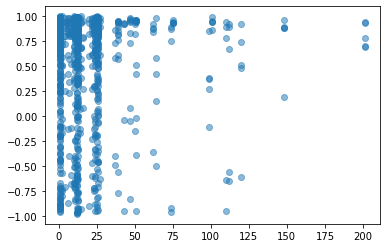

In [14]:
plt.scatter(df1["animeNumEpisode"], df1["compound"], alpha=0.5)
plt.show()

The Pearson's Correlation Coefficient is equal to 0.03979874058402419, so the number of episodes hasn't any impact on the sentiment of the users. 

**3. Is your sentiment analysis in line with the scores of the animes? Explain your conclusions.**

In [15]:
coeff = pearsonr(df1["animeScore"], df1["compound"])
coeff[0]

0.025202294639815187

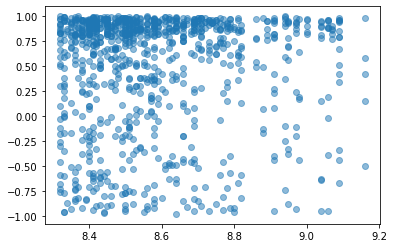

In [17]:
plt.scatter(df1["animeScore"], df1["compound"], alpha=0.5)
plt.show()

No, there isn't correlation because it's possible that a person’s tastes do not coincide with the overall score of the anime.

# [EX5] Algorithmic Question

You consult for a personal trainer who has a back-to-back sequence of requests for appointments. A sequence of requests is of the form > **30, 40, 25, 50, 30, 20** where each number is the time that the person who makes the appointment wants to spend. You need to accept some requests, however you need a break between them, so you cannot accept two consecutive requests. For example, **[30, 50, 20]** is an acceptable solution (of duration 100), but **[30, 40, 50, 20]** is not, because 30 and 40 are two consecutive appointments. Your goal is to provide to the personal trainer a schedule that maximizes the total length of the accepted appointments. For example, in the previous instance, the optimal solution is **[40, 50, 20]**, of total duration **110**.

## 5.1. Write an algorithm that computes the acceptable solution with the longest possible duration.

#### FIRST FUNCTION

The first function **isnot_adj** takes in input two arrays:
* **possiblesolution** that contains a possible sequence of accepted appointments.
* **applist** that contains the total sequence of requests. 

Considering all pairs of adjacent elements in possiblesolution and all pairs of adjacent elements in applist, if even only a couple of adjacent elements in the possiblesolution list is also contained within the applist the possible solution that we are considering is wrong and the function **isnot_adj** return **False**. If there aren't common couples of adjacent elements the possible solution is not wrong and the function **isnot_adj** return **True**.

input : array possiblesolution, array applist

def isnot_adj (possiblesolution, applist): {

    adj_app = list() empty list
    adj_sol = list() empty list
    for i in range (len(applist)):
        adj_app.append(applist[i], applist[i+1])
    for j in range (len(possiblesolution)):
        adj_sol.append(possiblesolution[j], possiblesolution[j+1])
    for z in range (len(adj_sol)):
        if(adj_sol[z] in adj_app):
            res.append("False")
        else:
            res.append("True")
    if ("False" in res):
        return (False)
    else:
        return (True)}

#### SECOND FUNCTION

The second function **optimalSolution** takes in input:
* **applist** that contains the total sequence of requests. 

the function calculate:
* **incl** that is the list that contains the sum including the previous element. The first element of incl is equal to the first element of applist, the i-th elements (considering i different to zero) are equal to the last element of excl list + the i-th element of applist.
* **excl** that is the list that contains the sum excluding the previous element. The fist element of excl is equal to zero, the i-th elements (considering i different to zero) are equal to the maximum value between the penultimate element of incl list and the last element of excl list. 
* **maximum** is calculated after finishing calculating incl and excl for each item in the applist and is equal to the maximum between the last element of incl list and the last element of excl list. This value is the optimal total duration of appointments. 
* **sol** contains the final solution. The final solution is the combination for which the sum of the list elements is equal to maximum and for which the function isnot_adj returns True.

input: array applist

def optimalSolution (applist):{

    incl, excl, sol: empty lists
    for i in range(len(applist)):
        if (i == 0):
            incl[0] = applist[0]
            excl[0] = 0
        else:
            incl[i] = excl[-1] + applist[i]
            excl[i] = max(incl[-2], excl[-1])
    maximum = max(excl[-1], incl[-1])
    for i in range (len(applist)):
        for x in combinations(applist,i):
            if(sum(x) == maximum and isnot_adj == True):
                sol.append(x)
    return maximum, sol}

## 5.2 Implement a program that given in input an instance in the form given above, gives the optimal solution.

In [4]:
import numpy as np
from more_itertools import pairwise
from itertools import combinations

In [39]:
def solutions (solution, appointments):
    adj_app, adj_sol, res = [], [], []
    [adj_app.append([x,y]) for x,y in pairwise(appointments)]
    [adj_sol.append([x,y]) for x,y in pairwise(solution)]
    for z in range (len(adj_sol)):
        if(adj_sol[z] in adj_app):
            res.append("False")
        else:
            res.append("True")
    if ("False" in res):
        return (False)
    else:
        return (True)

In [40]:
def optimal_solution (arr):
    incl, excl, sol = [], [], []
    for i in range(0,len(arr)):
        if (i == 0):
            incl.append(arr[0])
            excl.append(0)
        else:
            incl.append(excl[-1]+ arr[i])
            excl.append(max(incl[-2],excl[-1]))
    mymax = max(incl[-1], excl[-1])
    [sol.append(x) for i in range (len(arr)) for x in combinations(arr,i) if sum(x) == mymax and solutions(x, arr) == True]
    return mymax, sol

In [43]:
appointments = [30, 40, 25, 50, 30, 20]
duration, app = optimal_solution(appointments)
print ("The optimal solution is: ", app)
print ("The total duration is: ", duration)

The optimal solution is:  [(40, 50, 20)]
The total duration is:  110
